# **GRUPO #1 - PROYECTO ÁLGEBRA LINEAL**

### **1. Importación de librerías esenciales**
**Descripción:** Carga de paquetes fundamentales (`data.table`, `ggplot2`, `dplyr`) para la manipulación eficiente de datos y generación de gráficos.

In [ ]:
# Instalación de paquetes (solo si es necesario)
req_pkgs <- c("data.table", "ggplot2", "dplyr", "tidyr", "RColorBrewer")
to_install <- setdiff(req_pkgs, rownames(installed.packages()))
if (length(to_install) > 0) install.packages(to_install)

# Carga de librerías
suppressPackageStartupMessages({
  library(data.table)    # Lectura rápida de datos
  library(ggplot2)       # Visualización avanzada
  library(dplyr)         # Manipulación de data frames
  library(tidyr)         # Transformación de datos
  library(RColorBrewer)  # Paletas de colores
})

### **2. Preparación del Dataset (UCI HAR)**
**Descripción:** Descarga automática, limpieza de metadatos, selección de 12 variables cinemáticas y muestreo estratificado a 500 observaciones.

In [ ]:
# 1. Descarga y descompresion del dataset UCI HAR
zip_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
zip_file <- "UCI_HAR_Dataset.zip"
if (!file.exists(zip_file)) download.file(zip_url, zip_file, mode = "wb")
unzip(zip_file, exdir = ".")

# 2. Lectura de metadatos y limpieza de nombres
features <- fread("UCI HAR Dataset/features.txt", col.names = c("n","name"))
# Limpieza de nombres para evitar errores en R (quita parentesis y guiones)
feat_names <- gsub("[()-],", "_", gsub("\\(\\)", "", features$name))
feat_names <- make.names(gsub("-", "_", feat_names), unique = TRUE)

# 3. Lectura y combinacion de Train/Test
read_set <- function(type) {
  X <- fread(file.path("UCI HAR Dataset", type, paste0("X_", type, ".txt")))
  y <- fread(file.path("UCI HAR Dataset", type, paste0("y_", type, ".txt")))
  s <- fread(file.path("UCI HAR Dataset", type, paste0("subject_", type, ".txt")))
  colnames(X) <- feat_names
  cbind(subject = s$V1, activity = y$V1, X)
}
full_df <- rbind(read_set("train"), read_set("test"))

# 4. Mapeo de actividades al Espanol
act_labels <- c("Caminando", "Subiendo", "Bajando", "Sentado", "De pie", "Acostado")
full_df$activity <- factor(full_df$activity, levels = 1:6, labels = act_labels)

# 5. Seleccion de las 12 variables objetivo y Muestreo Estratificado (n=500)
target_vars <- c(
  "tBodyAcc_mean_X", "tBodyAcc_mean_Y", "tBodyAcc_mean_Z",
  "tBodyAcc_std_X",  "tBodyAcc_std_Y",  "tBodyAcc_std_Z",
  "tGravityAcc_mean_X", "tGravityAcc_mean_Y", "tGravityAcc_mean_Z",
  "tBodyAccJerk_mean_X", "tBodyAccJerk_mean_Y", "tBodyAccJerk_mean_Z"
)

# Filtrar columnas
small_df <- select(full_df, subject, activity, all_of(target_vars))

# Muestreo aleatorio estratificado para balancear clases
set.seed(123)
small_df <- group_by(small_df, activity)
small_df <- sample_n(small_df, size = 84) # Aprox 500 total / 6 clases
small_df <- ungroup(small_df)
small_df <- slice(small_df, 1:500) # Asegurar corte exacto en 500

# Imputacion simple (si hubiese NAs)
small_df <- mutate(small_df, across(where(is.numeric), ~ifelse(is.na(.), median(., na.rm=TRUE), .)))

message("Dataset listo. Dimensiones: ", nrow(small_df), " filas x ", ncol(small_df), " columnas.")

Dataset listo. Dimensiones: 500 filas x 14 columnas.



### **3. Cálculo Algebraico (SVD/PCA)**
**Descripción:** Estandarización de la matriz numérica (Z-score) y ejecución de la Descomposición en Valores Singulares para obtener los componentes.


In [ ]:
# 1. Separar matriz numerica y Estandarizar (Media 0, Varianza 1)
X_raw <- as.matrix(select(small_df, -subject, -activity))
X_scaled <- scale(X_raw) # Importante para PCA

# 2. Aplicar PCA (basado en SVD)
# prcomp en R usa svd() internamente.
# X = U * D * V' -> prcomp devuelve:
# sdev (D), rotation (V), x (Scores = U*D)
pca_res <- prcomp(X_scaled, center = FALSE, scale. = FALSE)

### **4. Inspección de Scores (Matriz U)**
**Descripción:** Visualización preliminar de las coordenadas de las observaciones proyectadas en el nuevo espacio dimensional reducido.

In [ ]:
# Extraer los scores (equivalente a U * Sigma)
U_scores <- pca_res$x

# Mostrar dimensiones y primeras filas
cat("Dimensiones de la matriz de Scores (U*Sigma):", dim(U_scores)[1], "x", dim(U_scores)[2], "\n")
print(head(U_scores[, 1:4], 5)) # Mostrar solo primeras 4 componentes

Dimensiones de la matriz de Scores (U*Sigma): 500 x 12 
           PC1        PC2         PC3         PC4
[1,] 0.8683211  0.2705712  0.07969378  0.13711113
[2,] 2.4684726  2.7893871  0.04641562 -0.03993905
[3,] 0.8945037 -2.2503368 -0.01296499  0.34886901
[4,] 1.4100954  1.7053968 -0.41646354 -0.58154151
[5,] 1.6668661  1.4375767 -0.59188508  0.22524142


### **5. Inspección de Cargas (Matriz V)**
**Descripción:** Visualización de la matriz de rotación (vectores propios) que define los coeficientes de las variables originales en cada componente.

In [ ]:
# Extraer la matriz de rotación (V)
V_loadings <- pca_res$rotation

# Mostrar dimensiones y primeras filas
cat("Dimensiones de la matriz de Rotación (V):", dim(V_loadings)[1], "x", dim(V_loadings)[2], "\n")
print(head(V_loadings[, 1:4], 5))

Dimensiones de la matriz de Rotación (V): 12 x 12 
                        PC1          PC2         PC3        PC4
tBodyAcc_mean_X -0.05915245  0.032019636 -0.09656705 -0.4908034
tBodyAcc_mean_Y -0.02131681  0.160591355  0.20396436  0.5611335
tBodyAcc_mean_Z -0.06645859  0.284718423  0.35887659  0.4650133
tBodyAcc_std_X   0.42898268 -0.005958607 -0.34683901  0.1696934
tBodyAcc_std_Y   0.44735120  0.002984084 -0.31209056  0.1547377


### **6. Cálculo de Varianza Explicada**
**Descripción:** Determinación numérica de la proporción de varianza retenida por cada componente y su acumulado total.

In [ ]:
# Calcular Varianza Explicada
# Varianza = (Desviacion Estandar)^2
var_explained <- pca_res$sdev^2
prop_var <- var_explained / sum(var_explained)
cum_var <- cumsum(prop_var)

# Mostrar resumen de las primeras componentes
summary_pca <- data.frame(
  PC = paste0("PC", 1:length(prop_var)),
  Varianza_Pct = round(prop_var * 100, 2),
  Acumulada_Pct = round(cum_var * 100, 2)
)
print(head(summary_pca, 6))

   PC Varianza_Pct Acumulada_Pct
1 PC1        33.17         33.17
2 PC2        14.14         47.31
3 PC3        10.11         57.42
4 PC4         9.32         66.74
5 PC5         8.68         75.42
6 PC6         7.47         82.89


### **7. Gráfico de Sedimentación (Scree Plot)**
**Descripción:** Visualización combinada de varianza individual, acumulada y valores singulares para determinar el número óptimo de componentes ($k$).

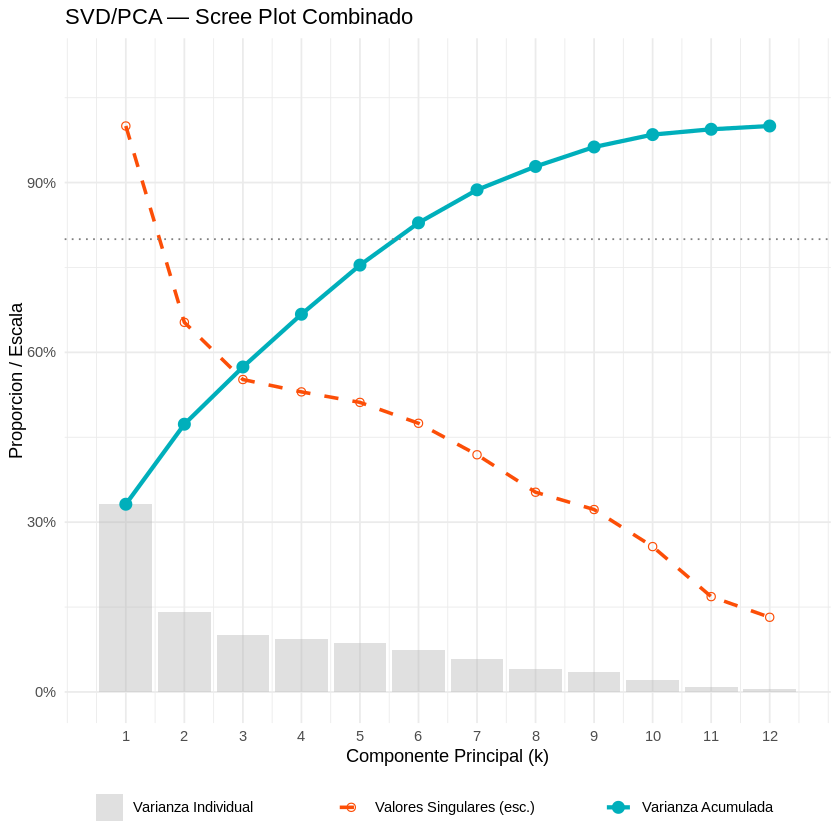

In [ ]:
# Preparar datos para el gráfico
df_plot <- summary_pca[1:12, ] # Usar las 12 componentes
df_plot$k <- 1:nrow(df_plot)
# Valor singular escalado (0-1) para comparar visualmente
df_plot$Singular_Escalado <- pca_res$sdev[1:12] / max(pca_res$sdev)

ggplot(df_plot, aes(x = k)) +
  # Barras de varianza individual
  geom_col(aes(y = Varianza_Pct/100, fill = "Varianza Individual"), alpha = 0.4) +
  # Linea de varianza acumulada
  geom_line(aes(y = Acumulada_Pct/100, color = "Varianza Acumulada"), linewidth = 1.2) +
  geom_point(aes(y = Acumulada_Pct/100, color = "Varianza Acumulada"), size = 3) +
  # Linea de Valores Singulares
  geom_line(aes(y = Singular_Escalado, color = "Valores Singulares (esc.)"),
            linetype = "dashed", linewidth = 1) +
  geom_point(aes(y = Singular_Escalado, color = "Valores Singulares (esc.)"),
             size = 2, shape = 1) +
  # Linea de corte referencial
  geom_hline(yintercept = 0.8, linetype = "dotted", color = "gray50") +

  # Estetica
  scale_y_continuous(labels = scales::percent, limits = c(0, 1.1)) +
  scale_x_continuous(breaks = 1:12) +
  scale_color_manual(values = c("Varianza Acumulada"="#00AFBB", "Valores Singulares (esc.)"="#FC4E07")) +
  scale_fill_manual(values = c("Varianza Individual"="gray70")) +
  labs(title = "SVD/PCA — Scree Plot Combinado",
       x = "Componente Principal (k)", y = "Proporcion / Escala") +
  theme_minimal() + theme(legend.position = "bottom", legend.title = element_blank())

### **8. Proyección 2D y Clustering**
**Descripción:** Gráfico de dispersión del plano PC1 vs PC2 con elipses de confianza para evaluar la separación entre actividades.

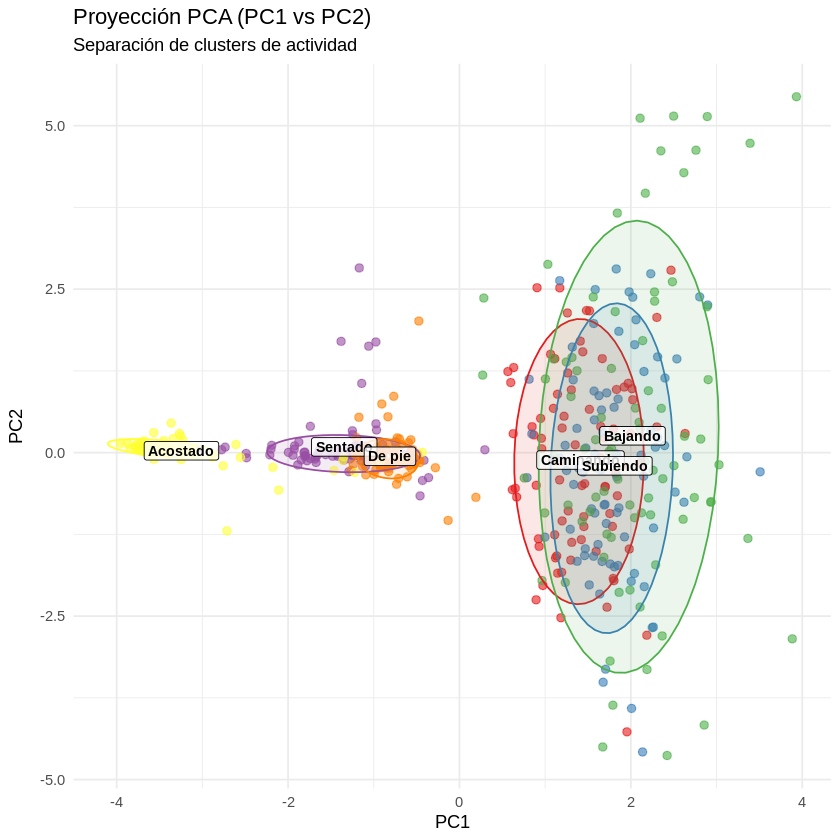

In [ ]:
# 1. Preparar datos de proyeccion
scores_df <- data.frame(
  activity = small_df$activity,
  PC1 = pca_res$x[, 1],
  PC2 = pca_res$x[, 2]
)

# 2. Calcular centroides
centroids <- summarise(group_by(scores_df, activity), PC1 = mean(PC1), PC2 = mean(PC2))

# 3. Grafico de Dispersion
ggplot(scores_df, aes(x = PC1, y = PC2, color = activity)) +
  geom_point(alpha = 0.6, size = 2) +
  stat_ellipse(aes(fill = activity), geom = "polygon", alpha = 0.1, level = 0.8) +
  geom_label(data = centroids, aes(label = activity),
             color = "black", fontface = "bold", size = 3, alpha = 0.8) +
  scale_color_brewer(palette = "Set1") +
  scale_fill_brewer(palette = "Set1") +
  labs(title = "Proyección PCA (PC1 vs PC2)",
       subtitle = "Separación de clusters de actividad",
       x = "PC1", y = "PC2") +
  theme_minimal() + theme(legend.position = "none")

### **9. Interpretación de Componentes (Heatmap)**
**Descripción:** Mapa de calor de las cargas factoriales para identificar visualmente qué variables originales dominan en cada componente principal.

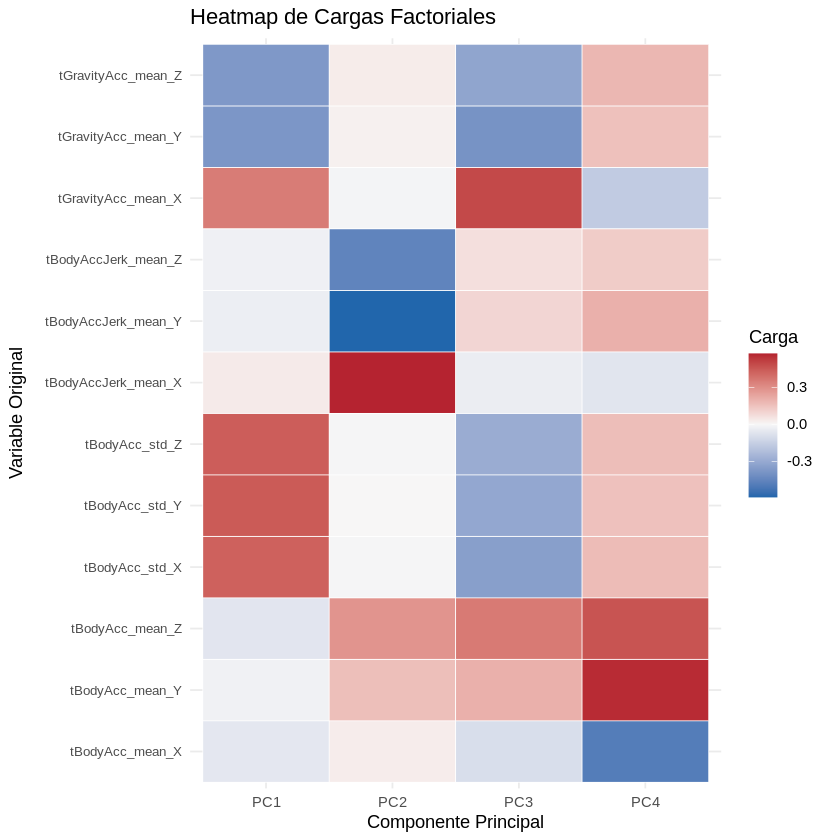

In [ ]:
# 1. Preparar datos
loadings <- as.data.frame(pca_res$rotation[, 1:4])
loadings$Variable <- rownames(loadings)
loadings_long <- pivot_longer(loadings, cols = starts_with("PC"), names_to = "PC", values_to = "Carga")

# 2. Heatmap
ggplot(loadings_long, aes(x = PC, y = Variable, fill = Carga)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "#2166ac", mid = "#f7f7f7", high = "#b2182b", midpoint = 0) +
  labs(title = "Heatmap de Cargas Factoriales",
       x = "Componente Principal", y = "Variable Original") +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 8))

### **10. Visualización Avanzada: Biplot (Flechas y Observaciones)**
**Descripción:** Generación de un gráfico Biplot que superpone las proyecciones de las actividades (puntos) y la dirección de las variables originales (vectores). Las flechas indican la contribución (peso) de cada variable a las Componentes Principales; su dirección y longitud señalan qué variables están más correlacionadas con la separación de los clusters.

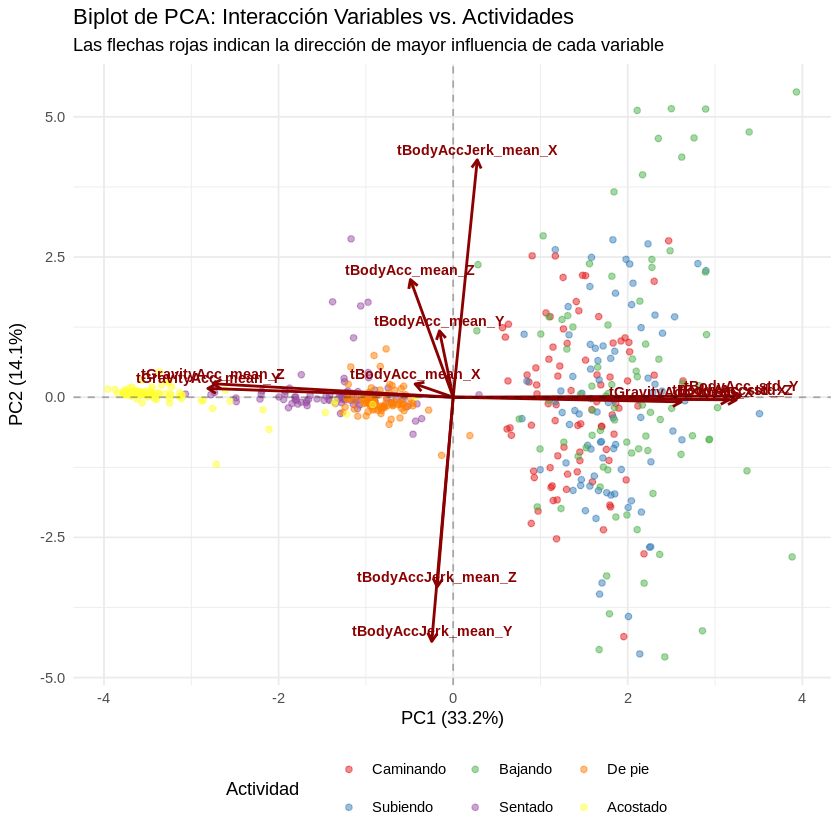

In [ ]:
# --- 1. Preparación de Datos de Carga (Flechas) ---
# Extraemos los vectores de carga (rotation) para PC1 y PC2
loadings_biplot <- as.data.frame(pca_res$rotation[, 1:2])
loadings_biplot$Variable <- rownames(loadings_biplot)

# --- 2. Factor de Escala para Visualización (Truco Matemático) ---
# Las cargas van de -1 a 1, pero tus datos (PC1, PC2) son números grandes.
# Calculamos un factor para "estirar" las flechas proporcionalmente.
max_score <- max(abs(pca_res$x[, 1:2]))    # Máximo valor de los puntos
max_loading <- max(abs(pca_res$rotation[, 1:2])) # Máximo valor de las flechas
scale_factor <- (max_score / max_loading) * 0.8  # El 0.8 es para que no toquen el borde

# Escalamos las coordenadas de las flechas para el gráfico
loadings_biplot$v1 <- loadings_biplot$PC1 * scale_factor
loadings_biplot$v2 <- loadings_biplot$PC2 * scale_factor

# --- 3. Generación del Biplot con ggplot2 ---
ggplot() +
  # Capa 1: Puntos (Observaciones / Actividades)
  geom_point(data = scores_df, aes(x = PC1, y = PC2, color = activity),
             alpha = 0.5, size = 1.5) +

  # Capa 2: Flechas (Variables Originales)
  # CORRECCIÓN: Se usa 'linewidth' en lugar de 'size' para evitar el warning
  geom_segment(data = loadings_biplot, aes(x = 0, y = 0, xend = v1, yend = v2),
               arrow = arrow(length = unit(0.2, "cm")), # Punta de flecha
               color = "darkred", linewidth = 0.8) +

  # Capa 3: Etiquetas de las Variables (en la punta de la flecha)
  geom_text(data = loadings_biplot, aes(x = v1, y = v2, label = Variable),
            color = "darkred", vjust = -0.5, hjust = 0.5, size = 3, fontface = "bold") +

  # Estética General
  scale_color_brewer(palette = "Set1") +
  labs(title = "Biplot de PCA: Interacción Variables vs. Actividades",
       subtitle = "Las flechas rojas indican la dirección de mayor influencia de cada variable",
       x = paste0("PC1 (", round(prop_var[1]*100, 1), "%)"),
       y = paste0("PC2 (", round(prop_var[2]*100, 1), "%)"),
       color = "Actividad") +
  theme_minimal() +
  theme(legend.position = "bottom") +
  geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.3) +
  geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.3)